In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [2]:
num_rep = 10
th_scaling = 10000
plot_colours = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

In [3]:
def read_fault(file_name):
    workers = []
    throughput_all_fault = []
    throughput = []
    times = []
    fault_rate = []
    graph_size = 150
    with open(file_name, "r") as in_file:
        for l in in_file:
            if l.startswith('END'):
                break
            if l.startswith('===='):
                for t in times:
                    throughput.append([graph_size * th_scaling  / (float(x) / 1000 ) for x in t])
                throughput_all_fault.append(throughput)
                throughput = []
                times = []
                continue
            elif l.startswith("worker spec,"):
                r = l.split(',')[2][0:-2]
                fault_rate.append(float(r))
            elif l.startswith("failure"): 
                fault_rate.append(float(l.split(',')[1]))
            elif l.startswith('[') or l.startswith(' {['):
                line = l.strip(" {}[],\n")
                line = line.replace("]", "")
                line = line.replace(" ", "")
                data = line.split(",")
                if not int(data[-1]) in workers:
                    workers.append(int(data[-1]))
                times.append(data[0: -1])
    return (throughput_all_fault, workers, fault_rate, graph_size)

In [4]:
throughput_all_fault, workers, fault_rate, graph_size = read_fault('../results/tc150_straggle.txt')

In [3]:
def plot(throughput, workers, ax, lbl, c):
    # confidence interval
    max_throughputs = [np.max(t) for t in throughput]
    min_throughputs = [np.min(t) for t in throughput]
    mean_throughputs = [np.mean(t) for t in throughput]
    err = [np.std(t) for t in throughput]

    # create flattened version
    workers_flat = np.array([[w] * num_rep for w in workers]).flatten()
    throughput_flat = throughput.flatten()

    ax.scatter(workers_flat, throughput_flat, s=6, alpha=0.8, color=c)
    ax.fill_between(workers, min_throughputs, max_throughputs, alpha=0.3)
    ax.errorbar(workers, mean_throughputs, yerr=err, label=lbl, color = c)


In [4]:
def plot_all(throughput_all, workers, graph_size, fault_rate):
  fig, ax = plt.subplots()
  fig.set_size_inches(18, 15)
  ax.set_title(f"throughput of tc against #workers on graph size {graph_size}")
  ax.set_xlabel("number of workers")
  ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.set_ylabel("throughput")
  for i, throughput in enumerate(throughput_all):
    plot(np.array(throughput), np.array(workers), ax, f"fault rate {fault_rate[i]}", plot_colours[i])
  ax.legend()


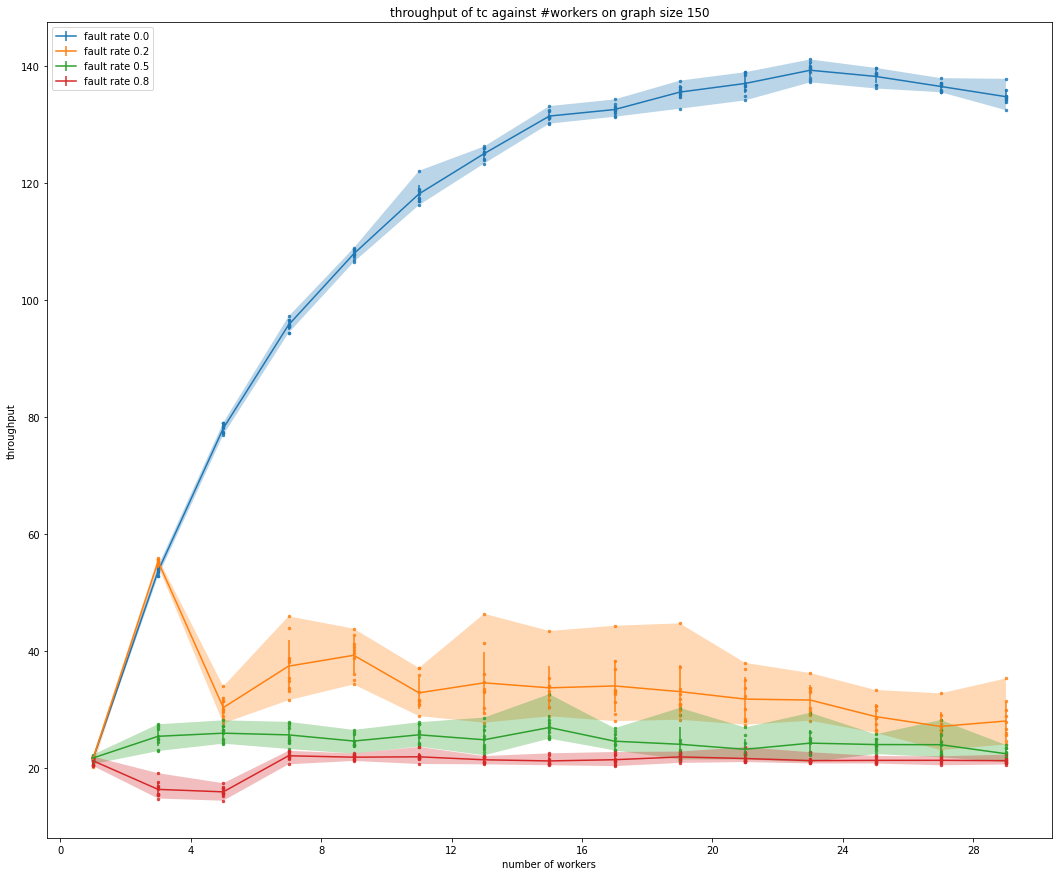

In [7]:
rates = [0, 1, 4, 9]
plot_all(np.array(throughput_all_fault), workers, graph_size, np.array(fault_rate))

In [5]:
def read_data2(file_name):
    workers = []
    throughput_all_input = []
    times = []
    graph_size = []
    with open(file_name, "r") as in_file:
        throughput = []
        for l in in_file:
            if l.startswith('graph'):
                graph_size.append(int(l.split(' ')[2]))
            if l.startswith('[') or l.startswith(' {'):
              line = l.strip(" {}[],\n")
              line = line.replace("]", "")
              line = line.replace(" ", "")
              data = line.split(",")
              if not (int(data[-1])) in workers:
                workers.append(int(data[-1]))
              times.append(data[0: -1])
            if l.startswith('='):
                throughput = []
                for t in times:
                    throughput.append([graph_size[-1] * th_scaling  / (float(x) / 1000 ) for x in t])
                throughput_all_input.append(throughput)
                times = []

    return (throughput_all_input, workers, graph_size)

In [9]:
(throughput_all_input, workers, graph_size) = read_data2('../results/rsg_th.txt')
throughput_all_input[0][8]

[47.03202302273965,
 37.995292383273714,
 46.859280175853506,
 46.78381614933357,
 47.57606377818745,
 46.733922701063705,
 40.82653816432126,
 47.84057453850949,
 41.02983406427299,
 46.86229299636471]

In [12]:
# x = throughput_all_input[0][8]
# x_bar = np.mean(np.array(x))
# s = np.std(x, ddof=1)
# T = (x[1] - x_bar) / s
# print(T)

-1.953741398822284


[100, 150, 200]


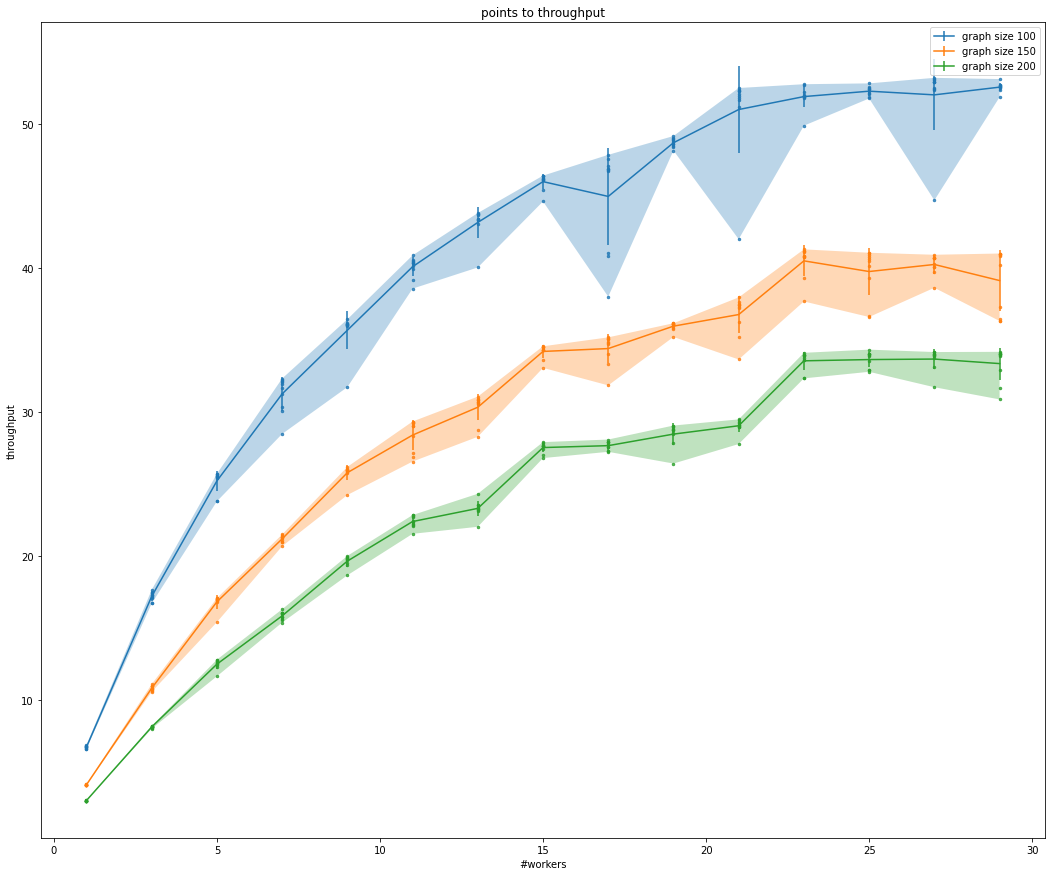

In [7]:
(throughput_all_input, workers, graph_size) = read_data2('../results/rsg_th.txt')
fig, ax = plt.subplots()
fig.set_size_inches(18,15)
print(graph_size)
for i,th in enumerate(throughput_all_input):
   plot(np.array(th), np.array(workers), ax, f"graph size {graph_size[i]}", plot_colours[i])
ax.legend()
ax.set_title("points to throughput")
ax.set_ylabel("throughput")
ax.set_xlabel("#workers")
plt.show()